Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Tesla T4, 15360 MiB, 15101 MiB


Saving poem2image (2).jpeg to poem2image (2).jpeg
Saving poem2image (3).jpeg to poem2image (3).jpeg
Saving poem2image (4).jpeg to poem2image (4).jpeg
Saving poem2image (5).jpeg to poem2image (5).jpeg
Saving poem2image (6).jpeg to poem2image (6).jpeg
Saving poem2image (7).jpeg to poem2image (7).jpeg
Saving poem2image (8).jpeg to poem2image (8).jpeg
Saving poem2image (9).jpeg to poem2image (9).jpeg
Saving poem2image (10).jpeg to poem2image (10).jpeg
Saving poem2image (11).jpeg to poem2image (11).jpeg
Saving poem2image (12).jpeg to poem2image (12).jpeg
Saving poem2image (13).jpeg to poem2image (13).jpeg
Cloning into 'diffusers'...
remote: Enumerating objects: 36685, done.
remote: Total 36685 (delta 0), reused 0 (delta 0), pack-reused 36685
Receiving objects: 100% (36685/36685), 29.78 MiB | 20.60 MiB/s, done.
Resolving deltas: 100% (26246/26246), done.
/content/diffusers
Processing /content/diffusers
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  

/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases 

  0%|          | 0/25 [00:00<?, ?it/s]

[*] Converted ckpt saved at /content/drive/MyDrive/AI_PICS/models/ptimodel.pth
Dreambooth completed successfully. It took 39.4 minutes.


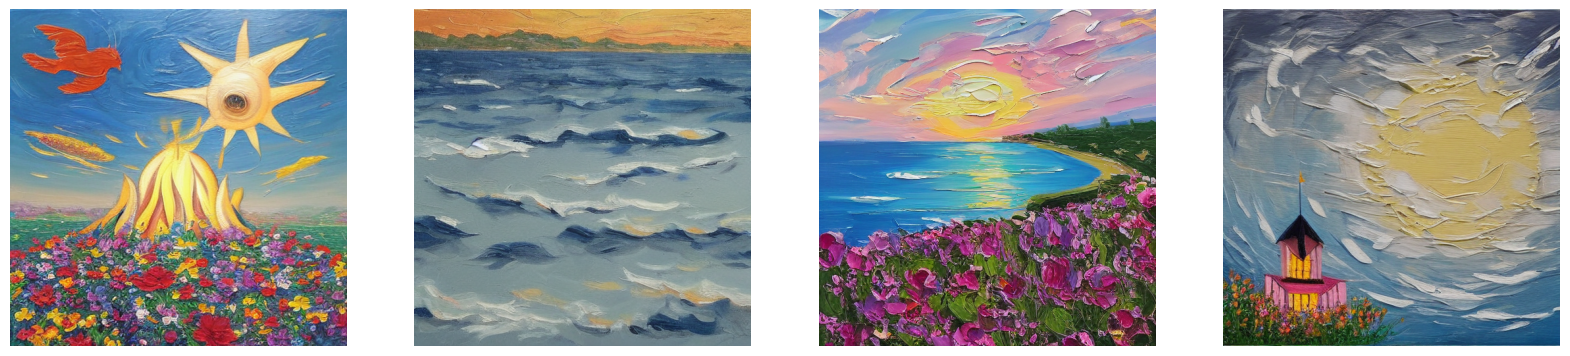

In [ ]:
import time


HUGGINGFACE_TOKEN = ""


MODEL_NAME = "runwayml/stable-diffusion-v1-5"
BRANCH = "fp16"


instance_prompt = "pti"
class_prompt =  "style"
training_steps = 500
learning_rate = 5e-6
output_file = "AI_PICS/models/ptimodel.pth"
#  Convert to fp16 (takes half the space (2GB)).
fp16 = True

#clear log after run
CLEAR_LOG = True

# Mount google drive for saving the model
from google.colab import drive
drive.mount('/content/drive')

OUTPUT_DIR = "/content/output"
INSTANCE_DIR = "/content/data/instance"
CLASS_DIR = "/content/data/class"
!mkdir -p $INSTANCE_DIR
!mkdir -p $CLASS_DIR

!rm -rf $OUTPUT_DIR
!mkdir -p $OUTPUT_DIR

if 'pipe' in locals():
  del pipe

# Check type of GPU and VRAM available.
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

# Upload training images.
import os
from google.colab import files
import shutil
uploaded = files.upload()
for filename in uploaded.keys():
    dst_path = os.path.join(INSTANCE_DIR, filename)
    shutil.move(filename, dst_path)

time_start = time.time()
def clear():
    from IPython.display import clear_output; return clear_output()

# huggingface token
!mkdir -p ~/.huggingface
!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token


# install diffusers
!git clone https://github.com/sagiodev/diffusers.git #https://github.com/huggingface/diffusers.git
%cd diffusers
!git checkout 08b453e3828f80027d881bb460716af95e192bcd -- ./scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install .


# install dreambooth
%cd /content/diffusers/examples/dreambooth
%pip install -r requirements.txt
%pip install bitsandbytes #xformers torch==2.1.0+cu121 # gradio natsort safetensors xformers torch==2.1.0+cu121 accelerate
!accelerate config default


# test bitsandbytes
import bitsandbytes
import torch
print(torch.__version__)

# Dreambooth training - Edit this section to customize parameters
!accelerate launch train_dreambooth.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --revision=$BRANCH \
  --instance_prompt="$instance_prompt" \
  --class_prompt="$class_prompt" \
  --class_data_dir=$CLASS_DIR \
  --instance_data_dir=$INSTANCE_DIR \
  --output_dir=$OUTPUT_DIR \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=$learning_rate \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=4 \
  --max_train_steps=$training_steps

#  --enable_xformers_memory_efficient_attention \

########################################
#prompt = "photo of zwx"
prompt = instance_prompt
negative_prompt = ""
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline,EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np



if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None




g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    fig=figure(figsize=(5*num_samples,5*num_samples))
    for i in range(num_samples):
        a=fig.add_subplot(1, num_samples,i+1)
        imshow(images[i])
        axis('off')


######################################
# Save to checkpoint file
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

/content


  0%|          | 0/25 [00:00<?, ?it/s]

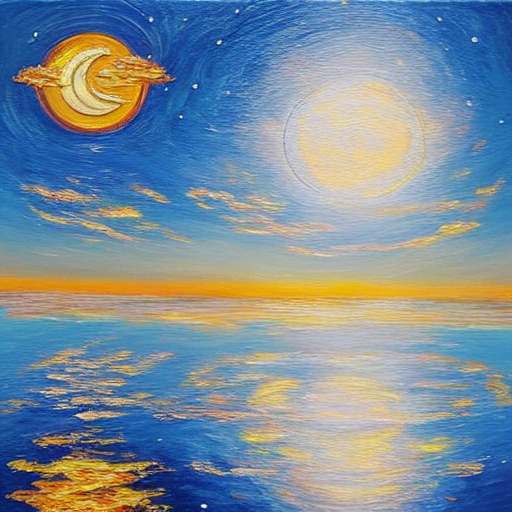

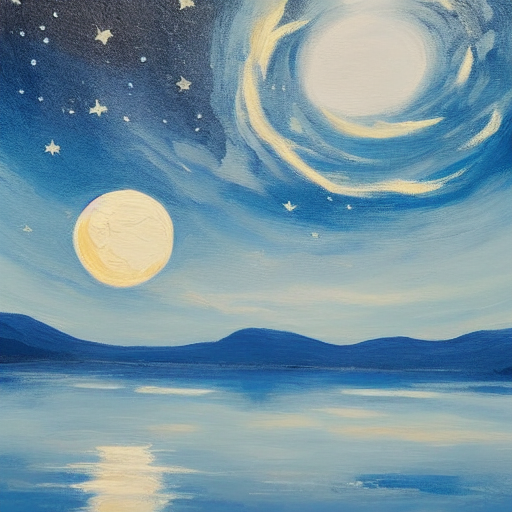

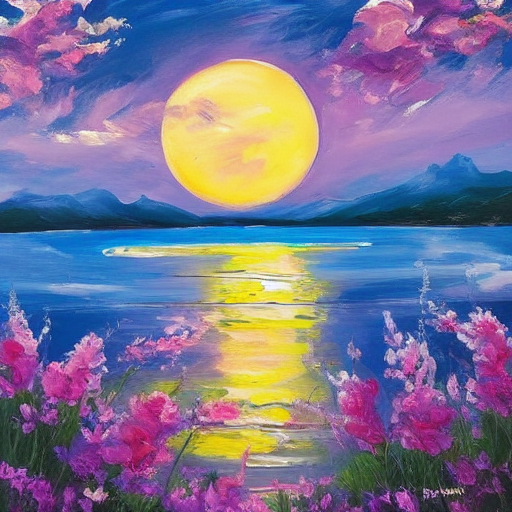

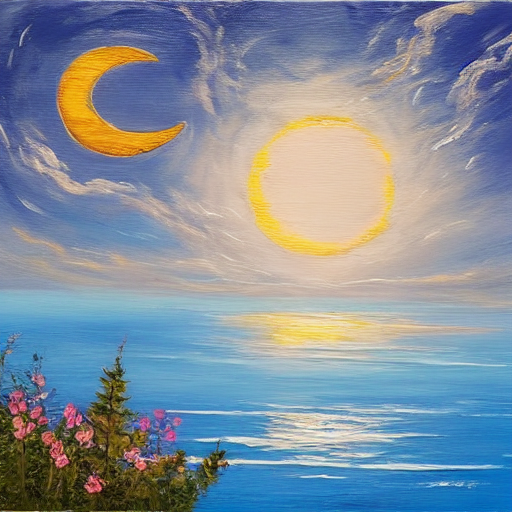

In [ ]:
#Test image generation


prompt = "moon light sky pti"
negative_prompt = "sofa, chair, dark, bad,  ugly"
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)

In [ ]:
#Test image generation
!pip install diffusers
import torch

prompt = "grey beach wind rain pti"
negative_prompt = "sofa, chair, dark, bad,  ugly"
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

OUTPUT_DIR = "/content/output"
%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


/content


ValueError: The provided pretrained_model_name_or_path "/content/output" is neither a valid local path nor a valid repo id. Please check the parameter.

/content


  0%|          | 0/25 [00:00<?, ?it/s]

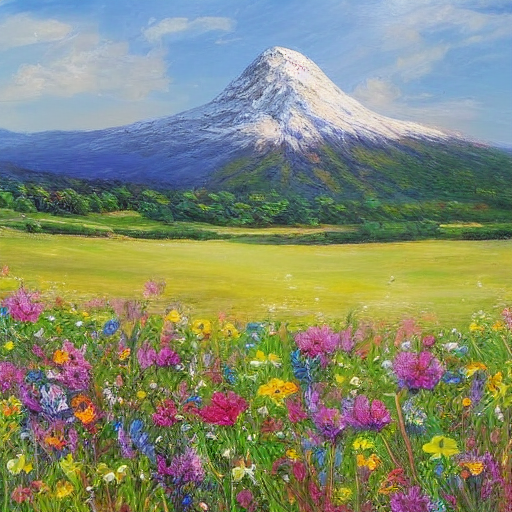

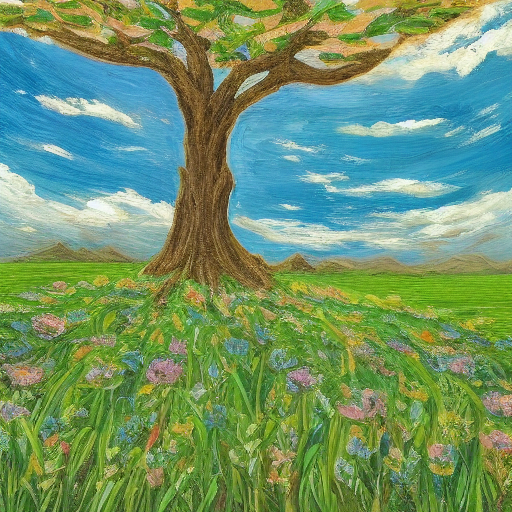

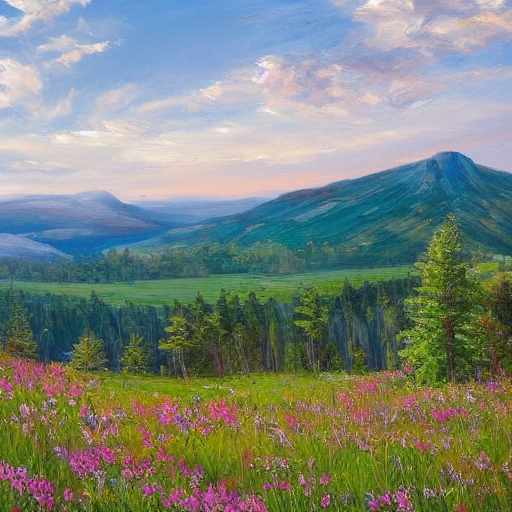

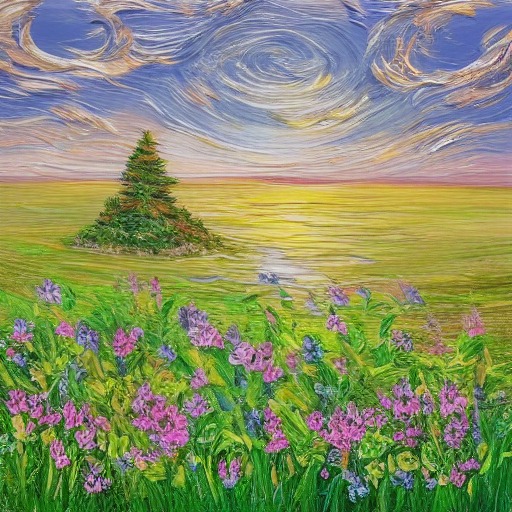

In [ ]:
#Test image generation

prompt = "tree grass lime mountain pti"
negative_prompt = "sofa, chair, dark, bad,  ugly"
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)

/content


  0%|          | 0/25 [00:00<?, ?it/s]

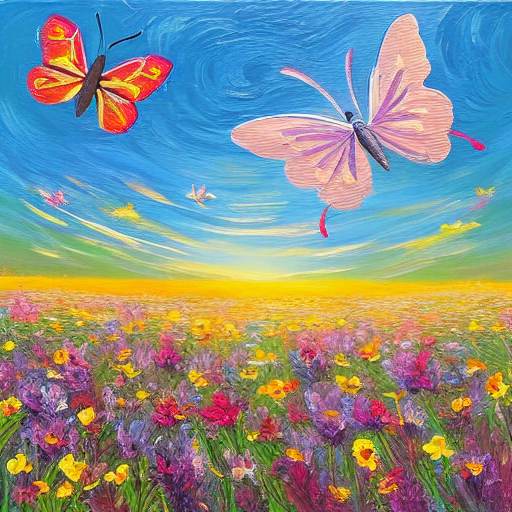

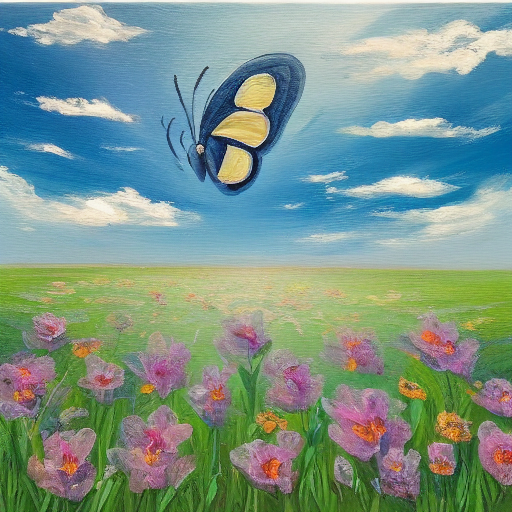

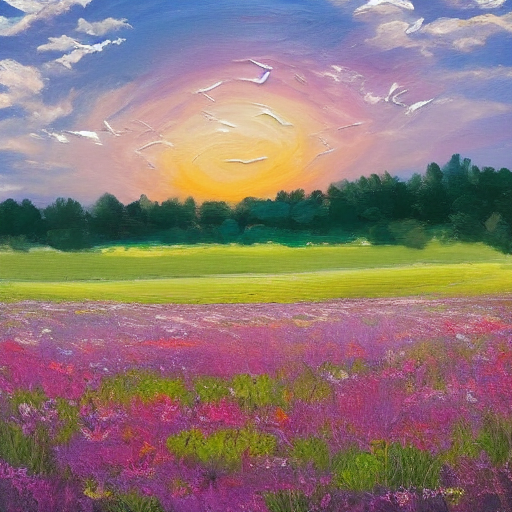

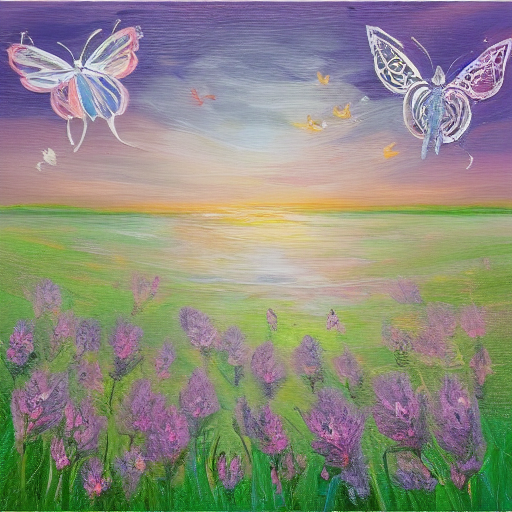

In [ ]:
#Test image generation

prompt = "shadow whisper meadow butterfly fields pti"
negative_prompt = "sofa, chair, dark, bad,  ugly, flower"
num_samples = 4
guidance_scale = 7.5
num_inference_steps = 25
height = 512
width = 512
seed = 100

%cd /content/
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
import numpy as np

if 'pipe' not in locals():
  pipe = StableDiffusionPipeline.from_pretrained(OUTPUT_DIR, safety_checker=None, torch_dtype=torch.float16).to("cuda")
  pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)
  g_cuda = None



g_cuda = torch.Generator(device='cuda')

g_cuda.manual_seed(seed)

from torch import autocast
with autocast("cuda"), torch.inference_mode():
    images = pipe(
        prompt,
        height=height,
        width=width,
        negative_prompt=negative_prompt,
        num_images_per_prompt=num_samples,
        num_inference_steps=num_inference_steps,
        guidance_scale=guidance_scale,
        generator=g_cuda
    ).images

    from ipywidgets import widgets, HBox
    from IPython.display import display
    for im in images:
        display(im)

In [ ]:

output_file = "AI_PICS/models/ptimodel2.safetensors"
ckpt_path = '/content/drive/MyDrive/' + output_file
# save model file. Save to a new name if already exist.
dirname= os.path.dirname(ckpt_path)
!mkdir -p $dirname
filename = os.path.basename(ckpt_path)
fileanmeWithoutExt = os.path.splitext(filename)[0]
ExtName = os.path.splitext(filename)[1]
filenamePattern = fileanmeWithoutExt + '%d' + ExtName
i = 1
while os.path.isfile(ckpt_path):
  filename = filenamePattern%i
  ckpt_path = dirname + '/' + filename
  i += 1

half_arg = "--half" if fp16 else ""
!python /content/diffusers/scripts/convert_diffusers_to_original_stable_diffusion.py \
    --use_safetensors \
    --model_path $OUTPUT_DIR \
    --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")
minutes = (time.time()-time_start)/60
print("Dreambooth completed successfully. It took %1.1f minutes."%minutes)

[*] Converted ckpt saved at /content/drive/MyDrive/AI_PICS/models/ptimodel2.safetensors
Dreambooth completed successfully. It took 68.8 minutes.
